# Import Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
from IPython.display import display, HTML

from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.weightstats import ztest
# import scipy 
# from scipy.stats import chi2_contingency
from scipy import stats
from scipy import interp

from collections import Counter
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imbpipeline
from pipelinehelper import PipelineHelper
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import recall_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.tree import DecisionTreeClassifier as DT 
from sklearn.ensemble import RandomForestClassifier as RF 
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier 
from sklearn.naive_bayes import GaussianNB as GB  
from sklearn.svm import SVC   

In [5]:
diabetes_df = pd.read_csv("https://raw.githubusercontent.com/jadanpl/Early-Diabetes-Detection-Using-Symptoms/main/diabetes_data.csv")

# Descriptive Statistics

In [6]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Age                 520 non-null    int64 
 1   Gender              520 non-null    object
 2   Polyuria            520 non-null    object
 3   Polydipsia          520 non-null    object
 4   sudden weight loss  520 non-null    object
 5   weakness            520 non-null    object
 6   Polyphagia          520 non-null    object
 7   Genital thrush      520 non-null    object
 8   visual blurring     520 non-null    object
 9   Itching             520 non-null    object
 10  Irritability        520 non-null    object
 11  delayed healing     520 non-null    object
 12  partial paresis     520 non-null    object
 13  muscle stiffness    520 non-null    object
 14  Alopecia            520 non-null    object
 15  Obesity             520 non-null    object
 16  class               520 no

In [7]:
diabetes_df.columns = diabetes_df.columns.str.lower()

In [8]:
diabetes_df.sample(5)

,age,gender,polyuria,polydipsia,sudden weight loss,weakness,polyphagia,genital thrush,visual blurring,itching,irritability,delayed healing,partial paresis,muscle stiffness,alopecia,obesity,class
54,51,Female,No,No,No,No,No,No,Yes,No,No,No,Yes,Yes,No,No,Positive
519,42,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Negative
480,46,Male,No,No,No,Yes,No,No,No,Yes,No,Yes,No,No,Yes,No,Negative
475,38,Male,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Negative
193,36,Male,Yes,No,No,Yes,No,Yes,Yes,Yes,No,Yes,No,No,No,No,Positive


In [9]:
pos = round(diabetes_df[diabetes_df['class']=='Positive'].describe(include='all'),2)
neg = round(diabetes_df[diabetes_df['class']=='Negative'].describe(include='all'),2)
pos_neg = pd.concat([pos, neg], axis=1, keys=['Positive','Negative'])
with pd.option_context('display.max_columns', None):
    display(HTML(pos_neg.to_html()))

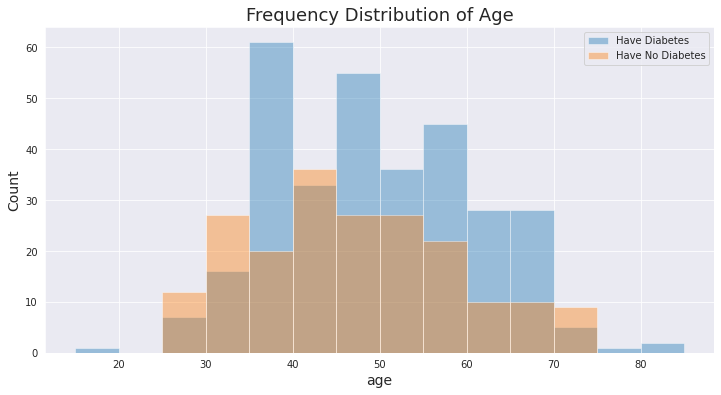

In [10]:
plt.figure(figsize=(12,6))
plt.hist(diabetes_df[diabetes_df['class']=='Positive']['age'], alpha=0.4, bins=np.arange(15, 90, 5),label='Have Diabetes')
plt.hist(diabetes_df[diabetes_df['class']=='Negative']['age'], alpha=0.4, bins=np.arange(15, 90, 5),label='Have No Diabetes')
plt.title('Frequency Distribution of Age',fontsize=18)
plt.xlabel('age',fontsize=14)
plt.ylabel('Count',fontsize=14)
plt.legend();

In [11]:
diabetes_df[(diabetes_df['class']=='Positive') & (diabetes_df['age']<=20) | (diabetes_df['age']>=75)]

,age,gender,polyuria,polydipsia,sudden weight loss,weakness,polyphagia,genital thrush,visual blurring,itching,irritability,delayed healing,partial paresis,muscle stiffness,alopecia,obesity,class
101,85,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
102,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive
113,79,Male,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,No,No,Positive
133,16,Male,Yes,No,Yes,No,Yes,No,No,No,No,No,No,No,No,No,Positive
185,85,Male,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No,No,Positive
186,90,Female,No,Yes,Yes,No,No,Yes,Yes,Yes,No,No,No,Yes,Yes,No,Positive


In [74]:
# fig, ax = plt.subplots(figsize=(18,20), facecolor='#F2F4F4',constrained_layout=True)

# count=1
# for i in diabetes_df.columns[1:-1]:
#     plt.subplot(5,3,count)
#     abs_val = diabetes_df[i].value_counts(ascending=False)
#     a = sns.countplot(diabetes_df[i], order=abs_val.index)
#     rel_val = diabetes_df[i].value_counts(ascending=False, normalize=True).values*100
#     lbs_val = [f"{a[0]} ({a[1]:.2f}%)" for a in zip(abs_val,rel_val)]
#     a.bar_label(container = a.containers[0], labels = lbs_val, fontsize=8)
#     plt.title(('number of respondents by ' + i).title(), fontsize=13)
#     count+=1
    
# plt.suptitle('Univariate Analysis of Variables',fontsize=24);

# Multivariate Analysis & Hypothesis Testing

In [13]:
labelencoder = LabelEncoder()
for i in diabetes_df[1:]:
    diabetes_df[i] = labelencoder.fit_transform(diabetes_df[i])

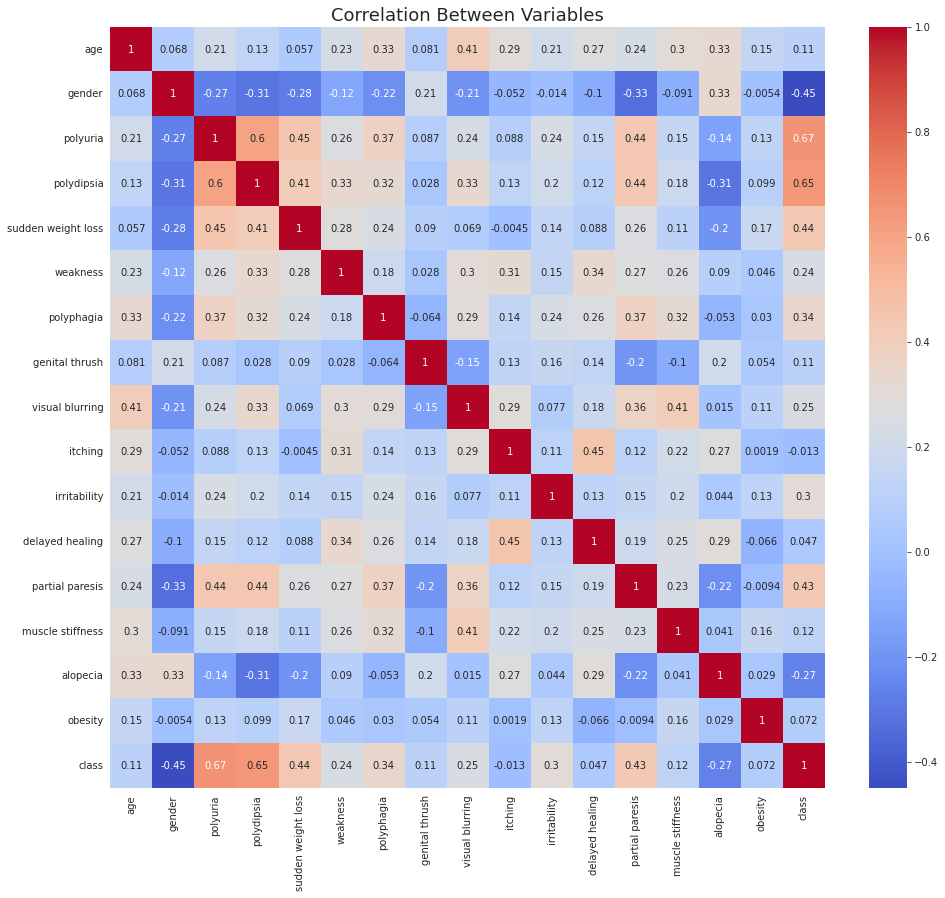

In [14]:
plt.figure(figsize = (16,14))
sns.heatmap(diabetes_df.corr(), annot=True, fmt='.2g',cmap='coolwarm')
plt.title('Correlation Between Variables', fontsize=18);

In [15]:
diabetes_obesity_crosstab = pd.crosstab(diabetes_df['obesity'], diabetes_df['class'])
Chisquares_diabetes_obesity = stats.chi2_contingency(diabetes_obesity_crosstab)
Chisquares_diabetes_obesity

Chi2ContingencyResult(statistic=2.327473958333334, pvalue=0.12710799319896815, dof=1, expected_freq=array([[166.15384615, 265.84615385],
       [ 33.84615385,  54.15384615]]))

In [16]:
gender_obesity_crosstab = pd.crosstab(diabetes_df['gender'], diabetes_df['class'])
Chisquares_gender_obesity = stats.chi2_contingency(gender_obesity_crosstab)
Chisquares_gender_obesity

Chi2ContingencyResult(statistic=103.03685927972559, pvalue=3.289703730553294e-24, dof=1, expected_freq=array([[ 73.84615385, 118.15384615],
       [126.15384615, 201.84615385]]))

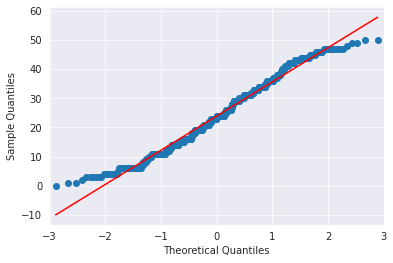

In [17]:
qqplot(diabetes_df['age'],line='s')
plt.show()

In [18]:
stats.shapiro(diabetes_df['age']) 

ShapiroResult(statistic=0.9785812497138977, pvalue=6.473160851783177e-07)

* Based on the qqplot (most points lied on the line) and the Shapiro result which showed that the p-value = 6.47e-07 < 0.05
* We can say that the distribution of the age is normally distributed and we can conduct the z-test.

In [19]:
w_diabetes = diabetes_df[diabetes_df['class']==1]
n_diabetes = diabetes_df[diabetes_df['class']==0] 
ztest(w_diabetes['age'], n_diabetes['age'])

(2.4358875641213964, 0.014855301229383732)

* With p-value = 0.014 < 0.05, we will reject the null hypothesis
* It is said that there is significant difference in the mean of age between people with diabetes and people without diabetes.

In [20]:
diabetes_df = pd.read_csv("https://raw.githubusercontent.com/jadanpl/Early-Diabetes-Detection-Using-Symptoms/main/diabetes_data.csv")
diabetes_df.columns = diabetes_df.columns.str.lower()

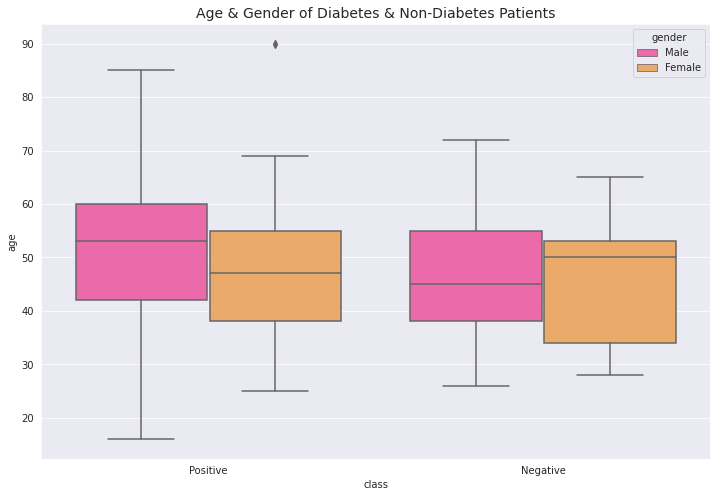

In [21]:
plt.figure(figsize=(12,8))
a = sns.boxplot(y='age', x='class', hue='gender',data=diabetes_df, palette='spring')
plt.title("Age & Gender of Diabetes & Non-Diabetes Patients", fontsize=14);

# Model Building & Evaluation

In [22]:
X = diabetes_df.drop(['class','obesity'], axis=1)
Y = diabetes_df['class'].map({'Negative':0,'Positive':1})

In [23]:
num_cols = ['age']
cat_cols = list(X.drop(['age'], axis=1))

full_pipeline = ColumnTransformer([
        ("num", MinMaxScaler(), num_cols),
        ("cat", OneHotEncoder(sparse=False, dtype='int', drop="if_binary"), cat_cols)])

In [24]:
# Create training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)

In [25]:
X_train = full_pipeline.fit_transform(X_train)
X_test = full_pipeline.transform(X_test)

In [26]:
classifiers = []
log_reg = LogisticRegression(max_iter=10000)
classifiers.append(log_reg)
knn_neg = KNeighborsClassifier(metric='euclidean') 
classifiers.append(knn_neg)
dt_model = DT(random_state=42)
classifiers.append(dt_model)
rf_model = RF(random_state=42)
classifiers.append(rf_model)
ab_model=AdaBoostClassifier(random_state=42)
classifiers.append(ab_model)
xgb_model = XGBClassifier(random_state=42)
classifiers.append(xgb_model)
GNB_model = GB() 
classifiers.append(GNB_model)
SVM_model = SVC(random_state=42)
classifiers.append(SVM_model)
classifiers

[LogisticRegression(max_iter=10000),
 KNeighborsClassifier(metric='euclidean'),
 DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42),
 AdaBoostClassifier(random_state=42),
 XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=None, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=None,
               predictor=None, random_state=42, ...),
 GaussianNB(),
 SVC(random_state=42)

In [27]:
recall_train = []
recall_test = []
for clf in classifiers:
    clf.fit(X_train, Y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    rn = round(recall_score(Y_train, pred_train, average='macro')*100,2)
    rt = round(recall_score(Y_test, pred_test, average='macro')*100,2)
    recall_train.append(rn)
    recall_test.append(rt)

In [28]:
original_result = pd.DataFrame(data={'Model':['LR','KNN','DT','RF','AdaBoost','XGB','Gaussian Bayes','SVM'],
                                     'Recall-Macro_Training (%)':recall_train,
                                     'Recall-Macro_Test (%)':recall_test})
original_result.sort_values(by=['Recall-Macro_Test (%)'],ascending=False)

,Model,Recall-Macro_Training (%),Recall-Macro_Test (%)
3,RF,100.00,98.00
5,XGB,100.00,97.75
2,DT,100.00,96.38
7,SVM,97.92,95.50
4,AdaBoost,95.38,93.62
1,KNN,95.92,92.62
0,LR,95.04,92.00
6,Gaussian Bayes,89.79,90.62


In [29]:
rc_mean_cv = []
rc_std_cv = []
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for i in classifiers:
    score = cross_val_score(i,X_train,Y_train,scoring='recall_macro', cv=kf)
    rc_mean_cv.append(round(score.mean()*100,2))
    rc_std_cv.append(round(score.std()*100,2))

In [30]:
cv_result = pd.DataFrame(data={'Model':['LR','KNN','DT','RT','AdaBoost','XGB','GNB','SVM'],
                               'Recall-Macro_Mean(%)':rc_mean_cv,
                               'Recall-Macro_SDev(%)':rc_std_cv})
cv_result.sort_values(['Recall-Macro_Mean(%)','Recall-Macro_SDev(%)'],ascending=False)

,Model,Recall-Macro_Mean(%),Recall-Macro_SDev(%)
3,RT,96.75,2.31
5,XGB,95.71,1.85
7,SVM,95.67,1.78
2,DT,95.46,2.82
1,KNN,94.75,1.52
0,LR,94.42,0.98
4,AdaBoost,91.58,2.88
6,GNB,89.46,1.88


### Handling imbalanced class with SMOTE-based techniques

In [31]:
diabetes_df['class'].value_counts()

Positive    320
Negative    200
Name: class, dtype: int64

* There is imbalanced class in the dataset, where the majority class belongs to the “0” (we denoted it as negative) label and the minority class belongs to the “1” (we denoted it as positive) label. 
* Hence, SMOTE based techniques (`SMOTE`, `ADASYN`, `SMOTEENN`, `SMOTETomek`) would be used to overcome this issue on the random forest model. 

In [32]:
# SMOTE
counter = Counter(Y_train)
print('Before',counter)
smt=SMOTE(random_state=42)
X_train_sm, Y_train_sm = smt.fit_resample(X_train, Y_train)
counter = Counter(Y_train_sm)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({1: 240, 0: 240})


In [33]:
# ADASYN
counter = Counter(Y_train)
print('Before',counter)
ada=ADASYN(random_state=42)
X_train_ada, Y_train_ada=ada.fit_resample(X_train, Y_train)
counter = Counter(Y_train_ada)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({1: 240, 0: 237})


In [34]:
# SMOTE-ENN
counter = Counter(Y_train)
print('Before',counter)
smenn=SMOTEENN(random_state=42)
X_train_smenn, Y_train_smenn=smenn.fit_resample(X_train, Y_train)
counter = Counter(Y_train_smenn)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({0: 232, 1: 215})


In [35]:
# SMOTE-TOMEK 
counter = Counter(Y_train)
print('Before',counter)
smtom=SMOTETomek(random_state=42)
X_train_smtom, Y_train_smtom=smtom.fit_resample(X_train, Y_train)
counter = Counter(Y_train_smtom)
print('After',counter)

Before Counter({1: 240, 0: 150})
After Counter({1: 239, 0: 239})


* Above are the SMOTE-based techniques to be used to handle imbalanced data. 
* Below is the function which involved: 
 1. Pipeline to handle the inbalanced dataset, scale the data, and run the data with a set of classifiers one by one. 
 2. Hyperparameter tuning process with 5-fold cross validation for each classifier to select the best model and its best parameters with the `PipelineHelper`. 

In [56]:
def diabetes_prediction(X,Y,smote=False,adasyn=False,smote_enn=False, smote_tomek=False):
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)
    
    trf = ColumnTransformer(transformers =[('cat',OneHotEncoder(sparse = False, drop ='first'),
                                               ['gender','polyuria','polydipsia','sudden weight loss',
                                                'weakness','polyphagia','genital thrush','visual blurring',
                                                'itching','irritability','delayed healing','partial paresis',
                                                'muscle stiffness','alopecia']),
                                           ('num',MinMaxScaler(), ['age'])],
                            remainder='passthrough')
    
    clf = [('log_reg', LogisticRegression(max_iter=10000)),
           ('knn_neg', KNeighborsClassifier(metric='euclidean')),
           ('dt_model', DT(random_state=42)),
           ('rf_model', RF(random_state=42)),
           ('ab_model', AdaBoostClassifier(random_state=42)),
           ('xgb_model', XGBClassifier(random_state=42)),
           ('GNB_model', GB()),
           ('SVM_model', SVC(random_state=42))]
    
    if (smote==True) & (adasyn==False) & (smote_enn==False) & (smote_tomek==False):
        pipeline = imbpipeline(steps = [('preprocessing',trf),
                                        ('smote', SMOTE(random_state=42)),
                                        ('classifier',PipelineHelper(clf))])
        
    elif (smote==False) & (adasyn==True) & (smote_enn==False) & (smote_tomek==False):
        pipeline = imbpipeline(steps = [('preprocessing',trf),
                                        ('adasyn', ADASYN(random_state=42)),
                                        ('classifier',PipelineHelper(clf))]) 
                               
    elif (smote==False) & (adasyn==False) & (smote_enn==True) & (smote_tomek==False):
        pipeline = imbpipeline(steps = [('preprocessing',trf),
                                        ('smote_enn', SMOTEENN(random_state=42)),
                                        ('classifier',PipelineHelper(clf))]) 
                                                               
    elif (smote==False) & (adasyn==False) & (smote_enn==False) & (smote_tomek==True):
        pipeline = imbpipeline(steps = [('preprocessing',trf),
                                        ('smote_tomek', SMOTETomek(random_state=42)),
                                        ('classifier',PipelineHelper(clf))])
                                         
    else:
        pipeline = imbpipeline(steps =[('preprocessing',trf),
                                       ('classifier',PipelineHelper(clf))])
    
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    
    param_grid={'classifier__selected_model': pipeline.named_steps['classifier'].generate(
                    {'log_reg__C':np.logspace(-10, 1, 15),
                     'log_reg__penalty':['l2'],
                     'knn_neg__n_neighbors': [2, 3, 5, 7, 10],
                     'knn_neg__leaf_size': [1, 2, 3, 5],
#                      'knn_neg__weights': ['uniform','distance'],
                     'dt_model__max_depth':[i for i in range(5,16,2)],
                     'dt_model__min_samples_split':[2, 5, 10, 15, 20, 50],
                     'dt_model__min_samples_leaf':[1, 2, 5],
                     'dt_model__max_features': [1,3,6],
                     'rf_model__max_depth': [3, 10, 30],
                     'rf_model__n_estimators': [10, 20, 50, 100, 150],
                     'rf_model__max_features':  [i for i in range(5,20,2)],
                     'ab_model__n_estimators': [10, 20, 40, 100],
                     'ab_model__algorithm': ['SAMME', 'SAMME.R'],
                     'xgb_model__n_estimators': [10, 20, 50, 100],
                     'xgb_model__max_depth': [3, 10, 30],
                     'xgb_model__gamma': [3,5,7,9],
                     'xgb_model__min_child_weight' : [3,7,10],
                     'SVM_model__C': [0.1, 1.0],
                     'SVM_model__kernel': ['linear', 'rbf'],
                     'SVM_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]})
               }

    grid_search = GridSearchCV(pipeline, param_grid, cv=kf, 
                               scoring='recall_macro',
                               verbose=1, n_jobs=-1)
    grid_search.fit(X_train, Y_train)
    print(grid_search.best_params_)
    cv_score = grid_search.best_score_
    test_score = grid_search.score(X_test, Y_test)
    print(f'Cross-validation score: {round(cv_score*100,2)}% \nTest score: {round(test_score*100,2)}%')                                                           

In [57]:
%%time
diabetes_prediction(X,Y,smote=True,adasyn=False,smote_enn=False,smote_tomek=False)

Fitting 10 folds for each of 652 candidates, totalling 6520 fits
{'classifier__selected_model': ('log_reg', {'C': 1e-10, 'penalty': 'l2'})}
Cross-validation score: 75.96% 
Test score: 82.75%
CPU times: user 15.4 s, sys: 447 ms, total: 15.8 s
Wall time: 4min 13s


In [58]:
%%time
diabetes_prediction(X,Y,smote=False,adasyn=True,smote_enn=False,smote_tomek=False)

Fitting 10 folds for each of 652 candidates, totalling 6520 fits
{'classifier__selected_model': ('log_reg', {'C': 1e-10, 'penalty': 'l2'})}
Cross-validation score: 54.67% 
Test score: 50.0%
CPU times: user 16.6 s, sys: 489 ms, total: 17.1 s
Wall time: 4min 34s


In [59]:
%%time
diabetes_prediction(X, Y, smote=False,adasyn=False,smote_enn=True,smote_tomek=False)

Fitting 10 folds for each of 652 candidates, totalling 6520 fits
{'classifier__selected_model': ('log_reg', {'C': 1e-10, 'penalty': 'l2'})}
Cross-validation score: 50.0% 
Test score: 50.0%
CPU times: user 16.4 s, sys: 506 ms, total: 16.9 s
Wall time: 4min 42s


In [60]:
%%time
diabetes_prediction(X, Y, smote=False,adasyn=False,smote_enn=False,smote_tomek=True)

Fitting 10 folds for each of 652 candidates, totalling 6520 fits
{'classifier__selected_model': ('log_reg', {'C': 1e-10, 'penalty': 'l2'})}
Cross-validation score: 75.96% 
Test score: 82.75%
CPU times: user 16.2 s, sys: 523 ms, total: 16.7 s
Wall time: 4min 34s


In [61]:
%%time
diabetes_prediction(X, Y, smote=False,adasyn=False,smote_enn=False,smote_tomek=False)

Fitting 10 folds for each of 652 candidates, totalling 6520 fits
{'classifier__selected_model': ('log_reg', {'C': 1e-10, 'penalty': 'l2'})}
Cross-validation score: 50.0% 
Test score: 50.0%
CPU times: user 12.9 s, sys: 319 ms, total: 13.2 s
Wall time: 3min 34s


# Final Model Selection

In [62]:
%%time
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42, stratify=Y)    
cat_cols = list(X.drop(['age'], axis=1))
preprocess = ColumnTransformer(transformers =[('cat',OneHotEncoder(sparse = False, dtype='int', drop="if_binary"),cat_cols),
                                              ('num',MinMaxScaler(), ['age'])],
                              remainder='passthrough')

final_pipeline = imbpipeline(steps=[('preprocessing',preprocess),
                                    ('smote_enn', SMOTEENN(random_state=42)),
                                    ('SVM_model', SVC(random_state=42))])

param_grid= [{'SVM_model__C': [0.2, 0.4, 0.6, 0.8, 1.0],
              'SVM_model__kernel': ['linear', 'rbf'],
              'SVM_model__gamma': [1, 0.1, 0.01, 0.001, 0.0001]}]

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(final_pipeline, param_grid, cv=kf, scoring='recall_macro',verbose=1, n_jobs=-1)
grid_search.fit(X_train, Y_train)
final_model = grid_search.best_estimator_
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, Y_test)
print(f'Cross-validation score: {round(cv_score*100,2)}% \nTest score: {round(test_score*100,2)}%')

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Cross-validation score: 95.38% 
Test score: 95.75%
CPU times: user 913 ms, sys: 35.8 ms, total: 949 ms
Wall time: 16.8 s


In [63]:
final_model

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(drop='if_binary',
                                                                dtype='int',
                                                                sparse=False),
                                                  ['gender', 'polyuria',
                                                   'polydipsia',
                                                   'sudden weight loss',
                                                   'weakness', 'polyphagia',
                                                   'genital thrush',
                                                   'visual blurring', 'itching',
                                                   'irritability',
                                                   'delayed healing',
                                    

In [64]:
pred_train = final_model.predict(X_train)
pred_test = final_model.predict(X_test)
recall_train = round(recall_score(Y_train, pred_train, average='macro')*100,2)
recall_test = round(recall_score(Y_test, pred_test, average='macro')*100,2)
print("Recall score from the final model (training data): ",recall_train,"%")
print("Recall score from the final model (testing data): ",recall_test,"%") 

Recall score from the final model (training data):  97.79 %
Recall score from the final model (testing data):  95.75 %


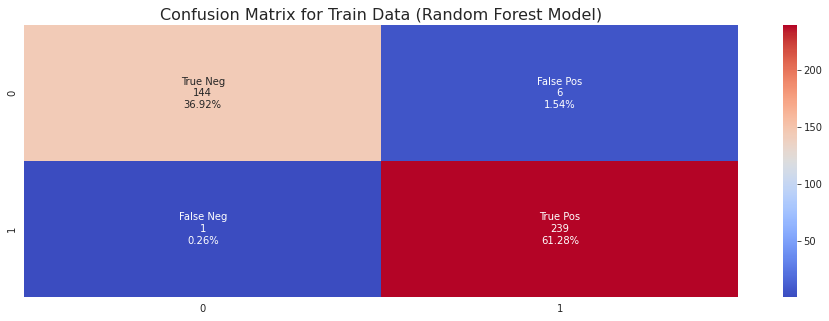

In [65]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
train_cnf_matrix = confusion_matrix(Y_train,pred_train)
train_counts = ["{0:0.0f}".format(value) for value in train_cnf_matrix.flatten()]
train_percentage = ["{0:.2%}".format(value) for value in train_cnf_matrix .flatten()/np.sum(train_cnf_matrix)]
train_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,train_counts,train_percentage)]
train_labels = np.asarray(train_labels).reshape(2,2)
plt.figure(figsize = (16,5))
sns.heatmap(train_cnf_matrix, annot=train_labels, fmt='', cmap='coolwarm')
plt.title('Confusion Matrix for Train Data (Random Forest Model)',fontsize=16);

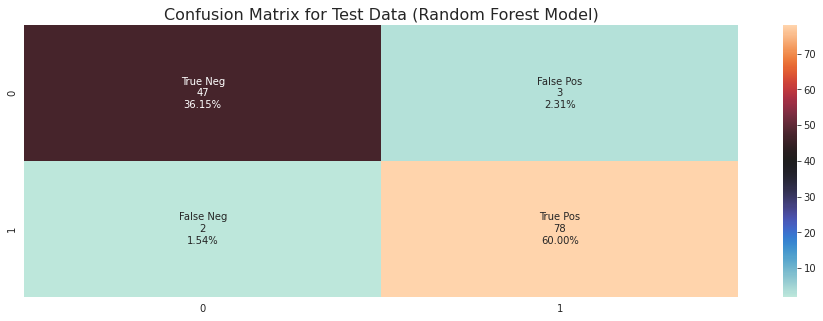

In [66]:
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
test_cnf_matrix = confusion_matrix(Y_test,pred_test)
test_counts = ["{0:0.0f}".format(value) for value in test_cnf_matrix.flatten()]
test_percentage = ["{0:.2%}".format(value) for value in test_cnf_matrix .flatten()/np.sum(test_cnf_matrix)]
test_labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,test_counts,test_percentage)]
test_labels = np.asarray(test_labels).reshape(2,2)
plt.figure(figsize = (16,5))
sns.heatmap(test_cnf_matrix, annot=test_labels, fmt='', cmap='icefire')
plt.title('Confusion Matrix for Test Data (Random Forest Model)',fontsize=16);

* To predict who will likely to have diabetes, we prefer algorithms that can score a high probability of finding out people who
have the same characteristics and actually have diabetes later (TRUE POSITIVE). 
* Based on the severity of the illness, we may also prefer that the algorithm wrongly chooses some people who don’t get ill after all rather than miss the people who actually do get ill (FALSE POSITIVE). 

In [67]:
print(f"{classification_report(Y_train,pred_train)}")

              precision    recall  f1-score   support

           0       0.99      0.96      0.98       150
           1       0.98      1.00      0.99       240

    accuracy                           0.98       390
   macro avg       0.98      0.98      0.98       390
weighted avg       0.98      0.98      0.98       390



In [68]:
print(f"{classification_report(Y_test,pred_test)}")

              precision    recall  f1-score   support

           0       0.96      0.94      0.95        50
           1       0.96      0.97      0.97        80

    accuracy                           0.96       130
   macro avg       0.96      0.96      0.96       130
weighted avg       0.96      0.96      0.96       130



# Making Prediction With New Input

In [69]:
def predict(model, inputs):
    input_df = pd.DataFrame([inputs])
    pred = model.predict(input_df)[0]
    if pred == 0:
        print('It is predicted that this patient does not have diabetes.')
    else: 
        print('It is predicted that this patient would have diabetes.')

In [70]:
male_input = {'age':25, 
               'gender':'Male', 
               'polyuria':'No', 
               'polydipsia':'No', 
               'sudden weight loss':'No',   
               'weakness':'No', 
               'polyphagia':'No', 
               'genital thrush':'No', 
               'visual blurring':'Yes',     
               'itching':'No', 
               'irritability':'No', 
               'delayed healing':'No', 
               'partial paresis':'No',
               'muscle stiffness':'Yes', 
               'alopecia':'No'}

In [71]:
predict(final_model, male_input)

It is predicted that this patient does not have diabetes.


In [72]:
female_input = {'age':25, 
               'gender':'Female', 
               'polyuria':'No', 
               'polydipsia':'No', 
               'sudden weight loss':'No',   
               'weakness':'No', 
               'polyphagia':'No', 
               'genital thrush':'No', 
               'visual blurring':'Yes',     
               'itching':'No', 
               'irritability':'No', 
               'delayed healing':'No', 
               'partial paresis':'No',
               'muscle stiffness':'Yes', 
               'alopecia':'No'}

In [73]:
predict(final_model, female_input)

It is predicted that this patient would have diabetes.
